# On the consistency of supervised learning with missing values
Authors: Julie Josse (CMAP, Inria), Nicolas Prost (CMAP, Inria), Erwan Scornet (CMAP), Gaël Varoquaux (Inria).
(Notebook by Nicolas Prost and Thomas Schmitt)


In [1]:
# Load library
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

# Regression problems

## Data generation ($X_{complete}, y$)

We consider 3 canonical regression problems where $X_{complete}$ is gaussian, and $y$ is either:
- the first coordinate of $X$ with noise ($y = X_0 + \varepsilon$)
- a linear function of $X$ with noise ($y = \beta  X + \varepsilon$)
- a quadratic function of the first coordinate with noise ($y = X_0^2 + \varepsilon$)

In [2]:
# python scripts to generate data
# Could be found here https://github.com/TwsThomas/supervised_missing/blob/master/Notebook/get_data.py
from get_data import generate_without_missing_values, generate_with_missing_values

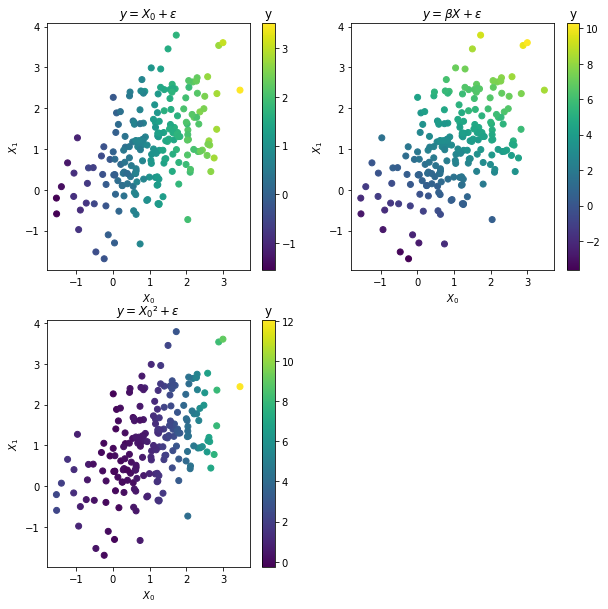

In [3]:
plt.figure(figsize=(10,10))
for id_plot, data in enumerate(['simple','linear','quadratic']):
    X, y = generate_without_missing_values(data=data)
    plt.subplot(2,2,id_plot+1)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('$X_0$')
    plt.ylabel('$X_1$')
    clb = plt.colorbar()
    clb.ax.set_title("y")
    if data == 'simple':
        plt.title('$y = X_0 + ε$')
    if data == 'linear':
        plt.title('$y = β X + ε$')
    if data == 'quadratic':
        plt.title('$y = X_0² + ε$')

## Data generation with missingness ($X, y$)

We consider three missing data mechanisms $M$ st. $X = X_{complete}.\mathbb{1}_{[M=0]} + \mbox{'NA'}.\mathbb{1}_{[M=1]}$

1. MCAR: values are missing completely at random, $M \sim \mathcal{B}(p)$  
2. Censored MNAR: values are missing only for high values of each variable, $M \sim \mathbb{1}_{[X>\alpha]}$  
3. Predictive missingness: $y$ depends of the missing mechanism, $y = f(X) + M$

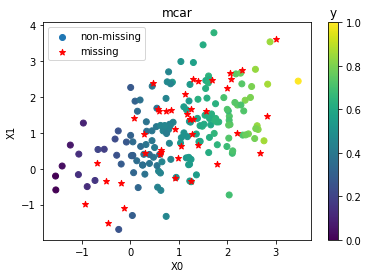

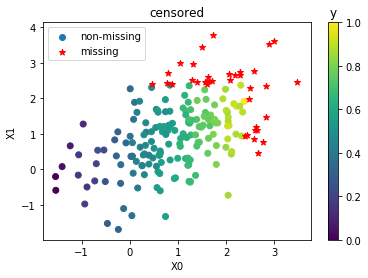

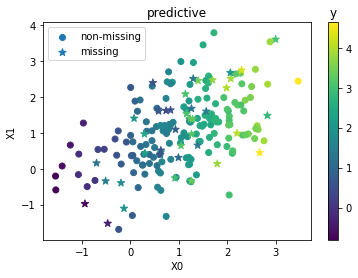

In [4]:
for mechanism in ['mcar','censored','predictive']:
    X, y, X_complete, M = generate_with_missing_values(missing_mechanism=mechanism)
    row_with_missing = [any(np.isnan(x)) for x in X]
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, label='non-missing', alpha = 1)
    if mechanism == 'predictive':
        plt.scatter(X_complete[row_with_missing, 0], X_complete[row_with_missing, 1],
                    marker='*', c=y[row_with_missing], s = 60, label='missing')
    else:
        plt.scatter(X_complete[row_with_missing, 0], X_complete[row_with_missing, 1],
                    marker='*', c='r', s = 40, label='missing')
    plt.legend()
    plt.xlabel("X0")
    plt.ylabel("X1")
    clb = plt.colorbar()
    clb.ax.set_title("y")

    plt.title(mechanism)

# Imputers and estimators

## Imputation strategies

We consider three imputation strategies:
1. Mean imputation: replace 'NA' by the mean of the feature (column)
2. Iterative imputation: each feature is regressed from the others
3. MIA (Missing In Attribute): duplicating features twice and remplacing its missing values once by $\infty$ and once by $- \infty$  

In the case of Mean or Iterative imputation, we also consider adding or not the missing values indicator (by concatening the indicator ("mask") to $X$)

/home/thomas/anaconda3/envs/stable/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


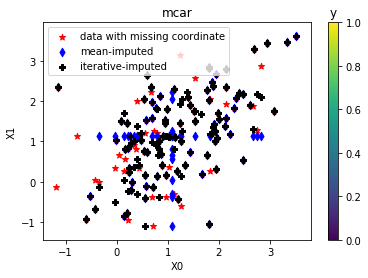

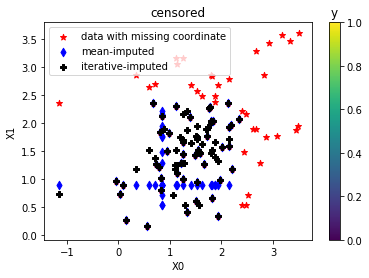

In [5]:
# examples of imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

for mechanism in ['mcar','censored']:
    X, y, X_complete, M = generate_with_missing_values(missing_mechanism=mechanism,
                                                       n_features=10)
    
    row_with_missing = [any(np.isnan(x)) for x in X]
    X_hat_mean = SimpleImputer(strategy='mean').fit_transform(X)
    X_hat_iterative = IterativeImputer().fit_transform(X)
    plt.figure()
    plt.scatter(X_complete[row_with_missing, 0], X_complete[row_with_missing, 1],
                marker='*', c='r',
                s = 40, label='data with missing coordinate', alpha=1)
#     plt.scatter(X[:, 0], X[:, 1], c='white', label='non-missing', alpha = 1)
    plt.scatter(X_hat_mean[row_with_missing, 0], X_hat_mean[row_with_missing, 1],
                marker='d', c='blue',
                label='mean-imputed', alpha = 1)
    plt.scatter(X_hat_iterative[row_with_missing, 0], X_hat_iterative[row_with_missing, 1],
                marker='P', c='black',
                label='iterative-imputed', alpha = 1)
    plt.legend()
    plt.xlabel("X0")
    plt.ylabel("X1")
    clb = plt.colorbar()
    clb.ax.set_title("y")
    plt.title(mechanism)
    

## Estimator
Concerning the estimator, which will modelizes $y$ from $\hat{X}$ ($X$-imputed) we use RandomForest with its default parameters.

Note: The imputation strategy (e.g. compute the mean or a regression) is learned on the train data. Then the **same** imputation will be used on the test data. This might allows RandomForest to 'understand' that the mean value could be representing a missing value.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from utils import MIAImputer  # allow to impute with inf and -inf
# Code could be found here https://github.com/TwsThomas/supervised_missing/blob/master/Notebook/utils.py

# XGBoost, RandomForest, HistGradientBoostingRegressor ??
boosting_with_mean_imputation = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')),
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=None))
])   
boosting_with_iterative_imputation = Pipeline([
    ('Iterative imputation', IterativeImputer()), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=None))
])
boosting_with_mean_imputation_and_mask = Pipeline([
    ('Mean imputation and mask', SimpleImputer(strategy='mean', add_indicator=True)), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=None))
])   
boosting_with_iterative_imputation_and_mask = Pipeline([
    ('Iterative imputation and mask', IterativeImputer(add_indicator=True)), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=None))
])
boosting_with_mia = Pipeline([
    ('Iterative imputation and mask', MIAImputer()), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=None))
])
boosting_with_mean_imputation_ = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')),
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=None))
])   
boostings = {
    'Mean': boosting_with_mean_imputation,
    'Iterative': boosting_with_iterative_imputation,
    'Mean+mask': boosting_with_mean_imputation_and_mask,
    'Iterative+mask': boosting_with_iterative_imputation_and_mask,
    'MIA': boosting_with_mia,
}

## Model evaluation

In order to evaluate our estimator (RandomForest), we plot:
- the learning curve: the evolution of the (cross-validated) prediction score versus the training size.
- a boxplot, easier to read, extracting one slice of the learning curve 

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, ShuffleSplit


def plot_learning_curve(estimators, missing_mechanism, data='simple'):
    """ Plot a learning curve for a dictionary of estimators """
    X, y, _, _ = generate_with_missing_values(data=data, n_samples=2 * 10 ** 5,
                                        n_features=10, missing_mechanism=missing_mechanism)
    sizes = np.logspace(2, 4, 7).astype(int)
    
    plt.figure(figsize=(5, 4))
    for key, est in estimators.items():
        train_sizes, _, valid_scores = learning_curve(
            est, X, y, train_sizes=sizes, scoring='r2', cv=8, random_state=0,
            n_jobs=-1)
        
        plt.plot(train_sizes, np.median(valid_scores, axis=1), label=key)
        plt.fill_between(train_sizes,
            np.percentile(valid_scores, q=25, axis=1),
            np.percentile(valid_scores, q=75, axis=1), alpha=0.2)
    
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlabel('Sample size')
    plt.ylabel('r2 score')
    plt.title(missing_mechanism)
    plt.xlim(train_sizes.min(), train_sizes.max())
    

def boxplot_scores(estimators, n_samples, missing_mechanism, data='simple', plot_id=2):
    """ Plot scores for a dictionary of estimators """
    X, y, _, _ = generate_with_missing_values(data=data, n_samples=2 * 10 ** 5,
                                        n_features=10, missing_mechanism=missing_mechanism)
    
    scores = {}
    for key, est in estimators.items():
        cv = ShuffleSplit(n_splits=8, train_size=n_samples, random_state=0)
        scores[key] = cross_val_score(
            est, X, y, scoring='r2', cv=cv, n_jobs=-1)

    mean_score = np.mean([score for score in scores.values()])
    relative_scores = {key:score-mean_score for (key,score) in scores.items()}

    if plot_id<=3:
        plt.title('Missing: {}'.format(missing_mechanism))
    if plot_id%3==1:
        plt.ylabel('data: {}'.format(data))
        labels = None
    else:
        labels = list(scores.keys())[::-1]
        
    bplot = plt.boxplot(list(scores.values())[::-1], labels=labels,
                        vert=False, patch_artist=True)
    # Add colors to boxplots
    for patch, color in zip(bplot['boxes'],
                            ['C0', 'C1', 'C2', 'C3','C4'][::-1]):
        patch.set_facecolor(color)

# Results

When data is missing completely at random, iterative imputation (with ot without the mask) has better finite sample properties than mean imputation: it converges faster. However, for censor data, iterative imputation performs poorly without the help of the indicator, while mean imputation seems self-sufficient.  

Text(0.5, 1.0, 'Learning curve of boosted trees for mcar data')

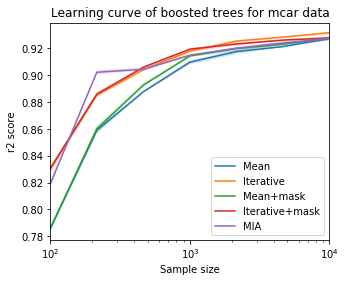

In [8]:
plot_learning_curve(boostings, 'mcar')
plt.title("Learning curve of boosted trees for mcar data")
# plt.savefig('learning_curve_boosting_mcar.svg')
# plt.savefig('learning_curve_boosting_mcar.pdf')

Iterative imputation converge faster.

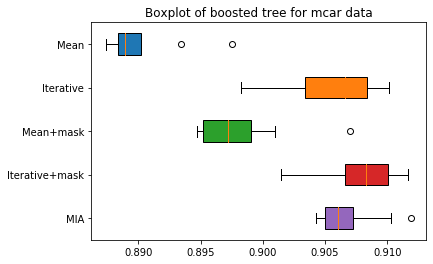

In [9]:
boxplot_scores(boostings, n_samples=500, missing_mechanism='mcar')
plt.title("Boxplot of boosted tree for mcar data");

When values are missing completly at random (MCAR), the mask (missing values indicator) does help Mean imputer. Iterative imputation beats Mean imputation wrt the regression performance.

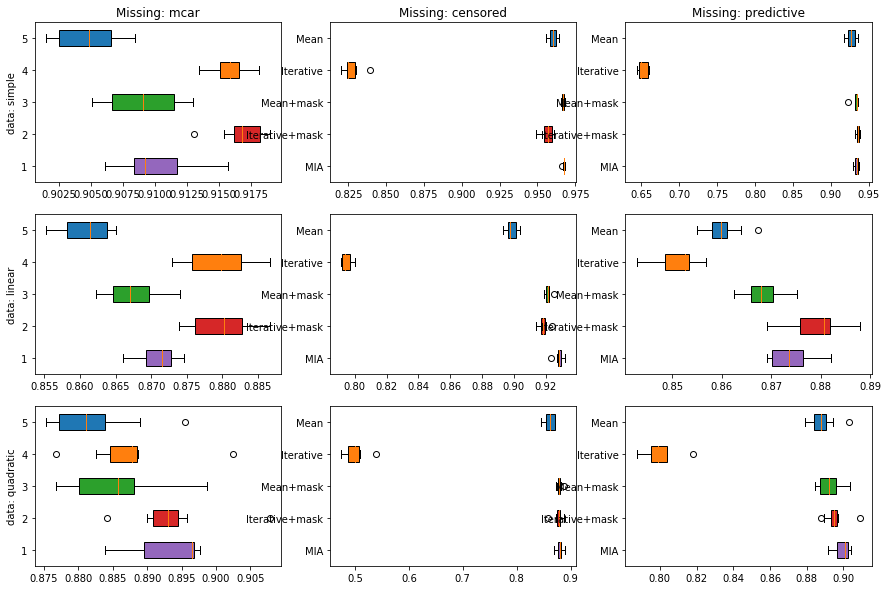

In [10]:
# boxplot for differents data and different missing mechanism
n_samples = 1000
plt.figure(figsize=(15,10))
for id_mm, missing_mechanism in enumerate(['mcar','censored','predictive']):
    for id_data, data in enumerate(['simple','linear','quadratic']):
        plot_id = id_mm + 3*id_data + 1
        plt.subplot(3,3,plot_id)
        boxplot_scores(boostings, n_samples, missing_mechanism, data, plot_id)

The graph above represent the boxplot scores for RandomForest on the three kind of data (one per row: 'Simple', 'linear', 'quadratic') and with the three kind of missing mechanism: (one per column: 'MCAR', 'Censored', 'Predictive')

## Going further

Using data = Friedman

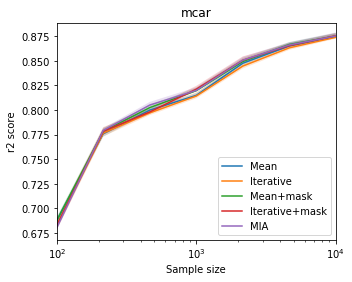

In [11]:
plot_learning_curve(boostings, 'mcar', data='friedman')

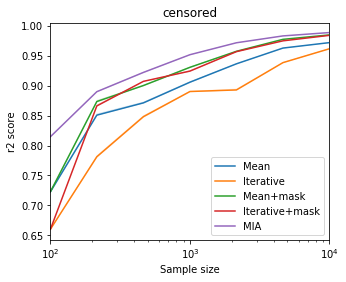

In [12]:
plot_learning_curve(boostings, 'censored', data='friedman')

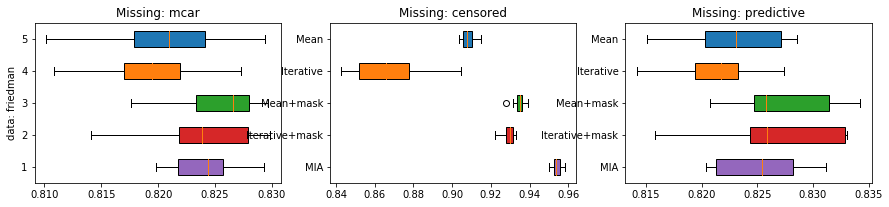

In [13]:
# boxplot for differents data and different missing mechanism
n_samples = 1000
plt.figure(figsize=(15,10))
for id_mm, missing_mechanism in enumerate(['mcar','censored','predictive']):
    for id_data, data in enumerate(['friedman']):
        plot_id = id_mm + 3*id_data + 1
        plt.subplot(3,3,plot_id)
        boxplot_scores(boostings, n_samples, missing_mechanism, data, plot_id)